# Lead Prediction
*Author: Max Smith*

Cleaned up version of 'Map Predicted Lead Danger,' which will be expanded upon.

In [34]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
# Constants & Script Parameters
RESIDENTIAL_TEST_DATA = "../../residential_test_data.csv"
PARCEL_GEO_DATA = "../../parcel_geo_data.tsv"

**Goal:** predict lead levels for untested parcels, to determine if action needs to be taken at these locations. A *parcel* is a distinct portion of land.

In [36]:
parcel_df = pd.read_csv(PARCEL_GEO_DATA, sep='\t')

In [37]:
column_titles = ['Property Zip Code','Owner Type', 'Owner State', 'Homestead',
                 'Homestead Percent', 'HomeSEV','Land Value', 
                 'Land Improvements Value', 'Residential Building Value', 
                 'Residential Building Style','Commercial Building Value',
                 'Building Storeys', 'Parcel Acres', 'Rental', 'Use Type', 
                 'Prop Class', 'Old Prop class', 'Year Built', 'USPS Vacancy',
                 'Zoning', 'Future Landuse', 'DRAFT Zone',
                 'Housing Condition 2012', 'Housing Condition 2014', 
                 'Commercial Condition 2013', 'Latitude',
                 'Longitude', 'Hydrant Type']

to_one_hot_cols = ['Property Zip Code', 'Owner Type', 
                   'Residential Building Style', 'Homestead', 
                   'Building Storeys', 'Rental', 'Use Type', 'Prop Class',
                   'Old Prop class', 'USPS Vacancy', 'Housing Condition 2012',
                   'Housing Condition 2014', 'Commercial Condition 2013',
                   'Hydrant Type']

to_drop_cols = ['Zoning', 'Future Landuse', 'DRAFT Zone', 'Owner State', 
                'Latitude', 'Longitude', 'Year Built']

label_cols = ['Lead (ppb)', 'Copper (ppb)']

In [38]:
# Raw training data
raw_X_df = pd.read_csv(RESIDENTIAL_TEST_DATA, usecols=column_titles)
raw_Y_df = pd.read_csv(RESIDENTIAL_TEST_DATA, usecols=label_cols)

### Feature Engineering

In [39]:
def featureEngineer(input_df):
    # Convert categorical values to one-hot
    output_df = pd.get_dummies(input_df[column_titles], columns=to_one_hot_cols)

    # Bin years
    output_df['Year Category'] = pd.cut(input_df['Year Built'],
                                        bins=[0,1927,1940,1950,1954,1959,2013])
    output_df = pd.get_dummies(output_df, columns=['Year Category'])
    
    # Drop unused columns
    output_df.drop(to_drop_cols, inplace=True, axis=1) # Inplace stops copying
    
    # Fix issue with typing of 'Homestead Percent'
    output_df['Homestead Percent'] = output_df['Homestead Percent'].astype(float)
    
    return output_df

In [40]:
# Need to combine test & training data to have consistent modifications


# Testing data

# We must remove any parcel ids that have already been tested
# in the training data, so we don't train on the testing data.
train_pids_df = pd.read_csv(RESIDENTIAL_TEST_DATA, usecols=['PID no Dash'])
train_pids = set(train_pids_df['PID no Dash'])

test_pids_mask = []
for pid in parcel_df['PID no Dash'].values:
    test_pids_mask.append(pid not in train_pids)
    
test_X = parcel_df[test_pids_mask].copy()

In [41]:
train_pids_df = pd.read_csv(RESIDENTIAL_TEST_DATA, usecols=['PID no Dash'])
train_pids = set(train_pids_df['PID no Dash'])

test_pids_mask = []
for pid in parcel_df['PID no Dash'].values:
    test_pids_mask.append(pid not in train_pids)
    
test_X = parcel_df[test_pids_mask].copy()

comb_data = raw_X_df.append(test_X)
comb_data = featureEngineer(comb_data).values

train_X = comb_data[:raw_X_df.shape[0],:]
test_X = comb_data[raw_X_df.shape[0]:,:]

train_Y = raw_Y_df['Lead (ppb)'] > 15

### Data Exploration

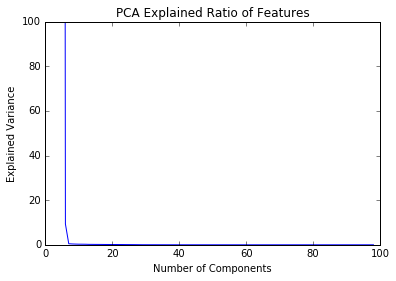

array([  6.12911554e+11,   6.00833984e+09,   2.36783698e+09,
         1.70070448e+09,   1.15287135e+09,   1.37190971e+03,
         9.31124974e+00,   4.70446972e-01,   3.75638510e-01,
         3.17526863e-01,   2.74587758e-01,   2.65855135e-01,
         2.45495295e-01,   1.97289234e-01,   1.92874581e-01,
         1.73883087e-01,   1.68914930e-01,   1.60074272e-01,
         1.43024014e-01,   1.39240641e-01,   1.32875744e-01,
         1.29842458e-01,   1.22472208e-01,   1.16535659e-01,
         9.82430692e-02,   9.32411255e-02,   8.18164180e-02,
         6.77858426e-02,   5.12782835e-02,   3.34246889e-02,
         3.14429048e-02,   2.82559627e-02,   2.75830584e-02,
         2.57763099e-02,   2.14101590e-02,   1.92625613e-02,
         1.50000955e-02,   1.35101897e-02,   1.13525698e-02,
         1.02489020e-02,   9.08531007e-03,   7.15301065e-03,
         6.39780148e-03,   6.16940082e-03,   5.73937278e-03,
         4.68200655e-03,   4.60251817e-03,   4.14204377e-03,
         3.85601796e-03,

In [48]:
# PCA
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(train_X)

plt.plot(pca.explained_variance_)
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")
plt.ylim(0, 100)
plt.title("PCA Explained Ratio of Features")
plt.show()

pca.explained_variance_

### Cross Validation

In [57]:
from sklearn.metrics import roc_curve, auc

from sklearn.cross_validation import KFold

import xgboost as xgb

model_xgb = xgb.XGBClassifier(colsample_bytree = 0.75,
                              colsample_bylevel = 1,
                              n_estimators = 32,
                              subsample = 1,
                              max_depth = 4,
                              gamma = 0,
                              seed = 42)

models = [model_xgb]
num_folds = 10

kf = KFold(train_X.shape[0], num_folds, shuffle=True)

for model in models:
    total = 0 # Rename
    
    for train_i, test_i in kf:
        # Get datasets for the fold
        train_X_fold = train_X[train_i, :]
        train_Y_fold = train_Y[train_i]
        
        test_X_fold = train_X[test_i, :]
        test_Y_fold = train_Y[test_i]

        model.fit(train_X_fold, train_Y_fold)
        predictions = model.predict_proba(test_X_fold)[:, 1]
        fpr, tpr, _ = roc_curve(test_Y_fold, predictions)
        total += auc(fpr, tpr)
    
    accuracy = total / num_folds
    print("{0}'s AUC: {1}".format(model, accuracy))


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.75,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=32, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=42, silent=True, subsample=1)'s AUC: 0.6495679292659493
